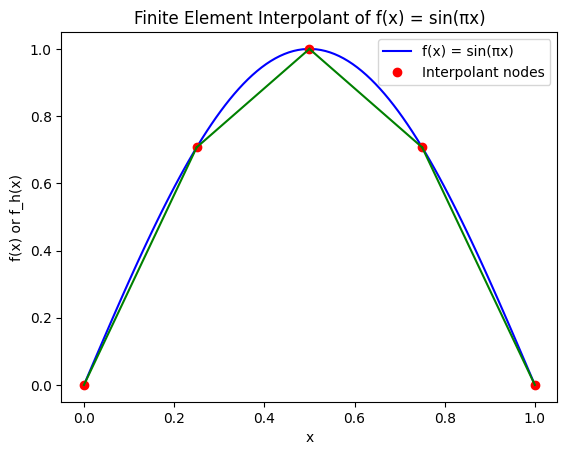

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(x) = sin(pi * x)
def f(x):
    return np.sin(np.pi * x)

# Define mesh points
x_nodes = np.linspace(0, 1, 5)  # 5 nodes from 0 to 1 for a uniform four-element mesh
f_values = f(x_nodes)

# Plot the original function and the finite element interpolant
x = np.linspace(0, 1, 100)
plt.plot(x, f(x), label='f(x) = sin(πx)', color='blue')
plt.plot(x_nodes, f_values, 'o', color='red', label='Interpolant nodes')

# Piecewise linear interpolant
for i in range(len(x_nodes) - 1):
    plt.plot([x_nodes[i], x_nodes[i+1]], [f_values[i], f_values[i+1]], color='green')

plt.legend()
plt.xlabel('x')
plt.ylabel('f(x) or f_h(x)')
plt.title('Finite Element Interpolant of f(x) = sin(πx)')
plt.show()


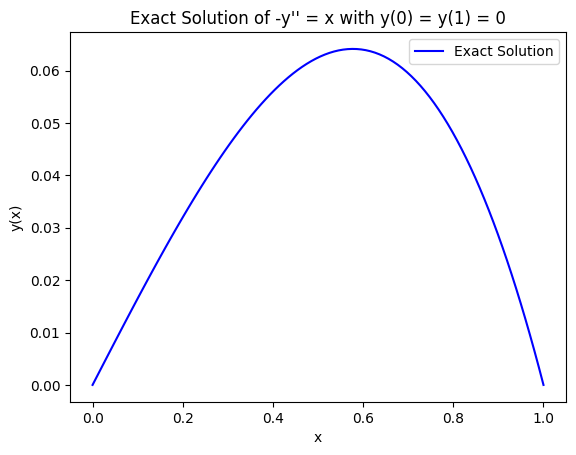

In [92]:
# Define the exact solution
def y_exact(x):
    return -x**3 / 6 + x / 6

# Plot the exact solution
x = np.linspace(0, 1, 100)
plt.plot(x, y_exact(x), label='Exact Solution', color='blue')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Exact Solution of -y\'\' = x with y(0) = y(1) = 0')
plt.legend()
plt.show()


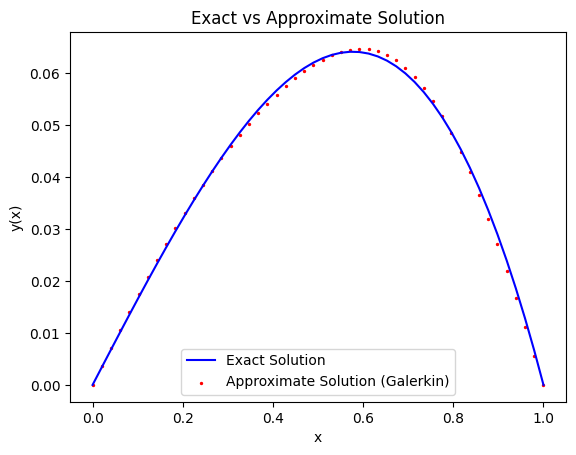

In [93]:
from scipy.integrate import quad

# Basis functions and their derivatives
def phi(i, x):
    return np.sin(i * np.pi * x)

def dphi(i, x):
    return i * np.pi * np.cos(i * np.pi * x)

# Define the stiffness matrix K and load vector f
N = 3
K = np.zeros((N, N))
f_vec = np.zeros(N)
# generally, could use:
"""
# Calculate K_ij
for i in range(1, N + 1):
    for j in range(1, N + 1):
        K[i - 1, j - 1] = quad(lambda x: dphi(i, x) * dphi(j, x), 0, 1)[0]

# Calculate f_i
for i in range(1, N + 1):
    f_vec[i - 1] = quad(lambda x: x * phi(i, x), 0, 1)[0]
"""
# simplified version (after calculating by hand)
K[np.diag_indices(N)] = (np.arange(1, N + 1) ** 2 * (np.pi ** 2)) / 2 # i**2 pi**2 /2

f_vec = ((-1) ** (np.arange(1, N + 1) + 1)) / (np.pi * np.arange(1, N + 1)) # -1 ** (i + 1) / (i*pi)

# Solve for coefficients c
c = np.linalg.solve(K, f_vec)

# Define the approximate solution yh(x)
def y_approx(x):
    return sum(c[i - 1] * phi(i, x) for i in range(1, N + 1))

# Plot the exact and approximate solutions
x = np.linspace(0, 1, 50)
plt.plot(x, y_exact(x), label='Exact Solution', color='blue')
plt.scatter(x, [y_approx(xi) for xi in x], marker  = "o", s = 2,label='Approximate Solution (Galerkin)', color='red')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Exact vs Approximate Solution')
plt.legend()
plt.show()


# 2.4 - Galerkin piece-wise linear finite element

[0.0390625 0.0625    0.0546875]


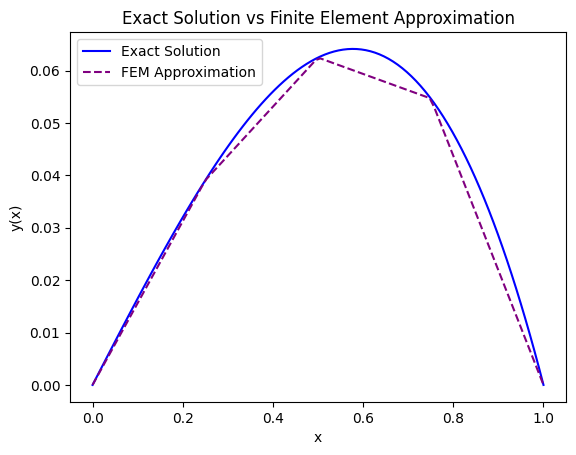

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Exact solution for reference
def y_exact(x):
    return -x**3 / 6 + x / 6

# Define nodes and elements
x_nodes = np.linspace(0, 1, 5)  # Four elements, mesh size h = 0.25
num_nodes = len(x_nodes)
num_elements = num_nodes - 1

# Define piecewise linear basis functions and their derivatives
def basis_functions(x, i, x_nodes, h):
    if i == 0:
        return (x_nodes[1] - x) / h if x_nodes[0] <= x < x_nodes[1] else 0
    elif i!= len(x_nodes):
        return (x - x_nodes[i-1]) / h if x_nodes[i-1] <= x <= x_nodes[i] else (x_nodes[i+1] - x) / h if x_nodes[i] <= x <= x_nodes[i+1] else 0
    else:
        return (x - x_nodes[i - 1]) / h if x_nodes[i - 1] < x <= x_nodes[i] else 0



# Populate K and f by integration over each element
def K_and_f(num_nodes, x_nodes, h):
    # Compute stiffness matrix K and load vector f
    K = np.zeros((num_nodes, num_nodes))
    f = np.zeros(num_nodes)
    # Fill K and f
    for i in range(1, num_nodes - 1):
        K[i, i] = 2 / h
        K[i, i-1] = -1 / h
        K[i, i+1] = -1 / h
        # f[i] = quad(lambda x: x * basis_functions(x, i, x_nodes,h), 0, 1)[0]# integral x * phi_i
        f[i] = quad(lambda x: x * basis_functions(x, i, x_nodes,h), x_nodes[i - 1], x_nodes[i + 1])[0]
        t= quad(lambda x: x * basis_functions(x, i, x_nodes,h), 0,1, epsrel=1e-8)[0]

        assert np.isclose(f[i], t), t# integral x * phi_i)
        # if i ==4:
        #     print("h" , h)
        #     print(x_nodes)
        #     print(quad(lambda x: x * basis_functions(x, i, x_nodes,h), 0, 1)[0])
    # f = np.array([1/96, 1/16, 1/8, 3/16, 11/96]) # this are the manually integrated values (by hand)


    # Apply boundary conditions by modifying K and f
    K = K[1:-1, 1:-1]  # Remove rows/columns for boundary y(0) = y(1) = 0 (we know the coefficients are 0)
    f = f[1:-1]
    return K, f
h = 0.25
K, f = K_and_f(num_nodes, x_nodes, h)
# Solve the linear system K * c = f
c = np.linalg.solve(K, f)
print(c)
# Approximate solution yh
def y_fem(x, c, num_nodes):
    return sum(c[i-1] * basis_functions(x, i, x_nodes,h) for i in range(1, num_nodes - 1))

# Plot exact and FEM solutions
x = np.linspace(0, 1, 100)
plt.plot(x, y_exact(x), label='Exact Solution', color='blue')
plt.plot(x, [y_fem(xi, c, num_nodes) for xi in x], label='FEM Approximation', color='purple', linestyle='--')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('Exact Solution vs Finite Element Approximation')
plt.show()



### recheck (ignore when grading, please).
We create a finer mesh grid to ensure the FEM is accurate/valid.

In [155]:

# Define nodes and elements for finer mesh
num_elements = 40
x_nodes = np.linspace(0, 1, num_elements + 1) 
num_nodes = len(x_nodes)


# Assemble stiffness matrix K and load vector f for finer mesh
h = x_nodes[1] - x_nodes[0]
K, f = K_and_f(num_nodes, x_nodes, h)

# Solve for coefficients
c = np.linalg.solve(K, f)
print(f)


# Plot exact and FEM solutions
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, y_exact(x_plot), label='Exact Solution', color='blue')
plt.scatter(x, [y_fem(xi, c, num_nodes) for xi in x], label='FEM Approximation', color='purple', s=5)#, linestyle='-')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('Exact Solution vs Refined FEM Approximation')
plt.show()


AssertionError: 0.0

[0.0390625 0.0625    0.0546875]


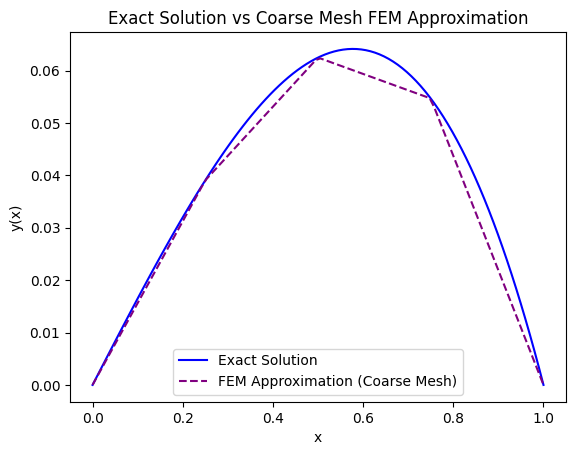

[0.00015625 0.0003125  0.00046875 0.000625   0.00078125 0.0009375
 0.00109375 0.00125    0.00140625 0.0015625  0.00171875 0.001875
 0.00203125 0.0021875  0.00234375 0.0025     0.00265625 0.0028125
 0.00296875 0.003125   0.00328125 0.0034375  0.00359375 0.00375
 0.00390625 0.0040625  0.00421875 0.004375   0.00453125 0.0046875
 0.00484375 0.005      0.00515625 0.0053125  0.00546875 0.005625
 0.00578125 0.0059375  0.00609375 0.00625    0.00640625 0.0065625
 0.00671875 0.006875   0.00703125 0.0071875  0.00734375 0.0075
 0.00765625 0.0078125  0.00796875 0.008125   0.00828125 0.0084375
 0.00859375 0.00875    0.00890625 0.0090625  0.00921875 0.009375
 0.00953125 0.0096875  0.00984375 0.01       0.01015625 0.0103125
 0.01046875 0.010625   0.01078125 0.0109375  0.01109375 0.01125
 0.01140625 0.0115625  0.01171875 0.011875   0.01203125 0.0121875
 0.01234375]


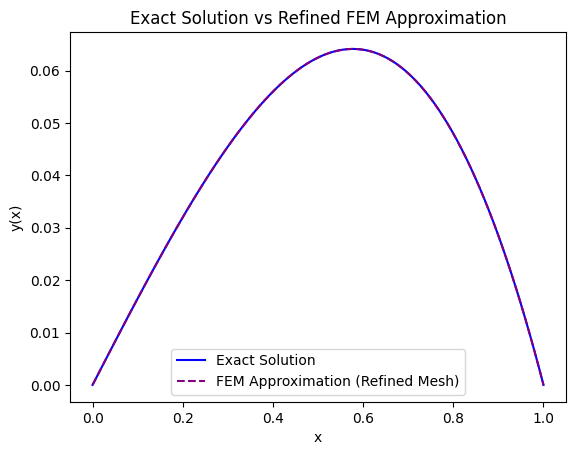

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Exact solution for reference
def y_exact(x):
    return -x**3 / 6 + x / 6

# Define piecewise linear basis functions
def basis_functions(x, i, x_nodes):
    h = x_nodes[1] - x_nodes[0]
    if i == 0:
        return (x_nodes[1] - x) / h if x_nodes[0] <= x <= x_nodes[1] else 0
    elif i == len(x_nodes) - 1:
        return (x - x_nodes[i - 1]) / h if x_nodes[i - 1] <= x <= x_nodes[i] else 0
    elif x_nodes[i - 1] <= x < x_nodes[i]:
        return (x - x_nodes[i - 1]) / h
    elif x_nodes[i] <= x <= x_nodes[i + 1]:
        return (x_nodes[i + 1] - x) / h
    return 0

# Populate K and f by integration over each element
def K_and_f(num_nodes, x_nodes, h):
    # Initialize stiffness matrix K and load vector f
    K = np.zeros((num_nodes, num_nodes))
    f = np.zeros(num_nodes)
    
    # Fill K and f
    for i in range(1, num_nodes - 1):
        # Stiffness matrix entries for each element
        K[i, i] = 2 / h
        K[i, i - 1] = -1 / h
        K[i, i + 1] = -1 / h
        # Load vector by integrating x * phi_i over each element
        f[i] = quad(lambda x: x * basis_functions(x, i, x_nodes), x_nodes[i - 1], x_nodes[i + 1])[0]
    
    # Apply boundary conditions by modifying K and f
    K = K[1:-1, 1:-1]  # Remove rows/columns for boundary y(0) = y(1) = 0
    f = f[1:-1]
    return K, f

# Coarse mesh example
x_nodes_coarse = np.linspace(0, 1, 5)  # Four elements, mesh size h = 0.25
num_nodes_coarse = len(x_nodes_coarse)
h_coarse = x_nodes_coarse[1] - x_nodes_coarse[0]

# Assemble K and f for coarse mesh
K_coarse, f_coarse = K_and_f(num_nodes_coarse, x_nodes_coarse, h_coarse)
c_coarse = np.linalg.solve(K_coarse, f_coarse)
print(c_coarse)
# Define FEM approximation function
def y_fem(x, c, x_nodes):
    return sum(c[i - 1] * basis_functions(x, i, x_nodes) for i in range(1, len(x_nodes) - 1))

# Plot exact and FEM solutions for coarse mesh
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, y_exact(x_plot), label='Exact Solution', color='blue')
plt.plot(x_plot, [y_fem(xi, c_coarse, x_nodes_coarse) for xi in x_plot], 
         label='FEM Approximation (Coarse Mesh)', color='purple', linestyle='--')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('Exact Solution vs Coarse Mesh FEM Approximation')
plt.show()

# Finer mesh example
num_elements_fine = 80
x_nodes_fine = np.linspace(0, 1, num_elements_fine + 1)
num_nodes_fine = len(x_nodes_fine)
h_fine = x_nodes_fine[1] - x_nodes_fine[0]

# Assemble K and f for finer mesh
K_fine, f_fine = K_and_f(num_nodes_fine, x_nodes_fine, h_fine)
c_fine = np.linalg.solve(K_fine, f_fine)
print(f_fine)
# Plot exact and FEM solutions for finer mesh
plt.plot(x_plot, y_exact(x_plot), label='Exact Solution', color='blue')
plt.plot(x_plot, [y_fem(xi, c_fine, x_nodes_fine) for xi in x_plot], 
         label='FEM Approximation (Refined Mesh)', color='purple', linestyle='--')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.title('Exact Solution vs Refined FEM Approximation')
plt.show()
